In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import requests
import os
df=pd.read_csv("updated_kuvera_funds.csv")

# ==== SETTINGS ====
SEQ_LEN = 60
FUTURE_DAYS = 260 * 5
BATCH_SIZE = 64
EPOCHS = 100

ISIN_LIST = df["isin"].tolist()[:30]  # Or entire list
MODEL_PATH = "5Y_LSTM_general_model.h5"

# ==== COLLECT DATA ACROSS FUNDS ====
all_X, all_y = [], []
fund_scalers = {}  # To save scalers for future prediction

for isin_number in ISIN_LIST:
    url = f"https://mf.captnemo.in/nav/{isin_number}"
    try:
        res = requests.get(url)
        if res.status_code != 200:
            print(f"⚠️ Failed to fetch for {isin_number}")
            continue

        nav_data = res.json()
        data = pd.DataFrame(nav_data['historical_nav'])
        data = data.rename(columns={0: 'Date', 1: 'Price'})
        data['Date'] = pd.to_datetime(data['Date'])
        data = data.sort_values('Date')
        data.set_index('Date', inplace=True)

        nav_prices = data['Price'].values
        nav_pct_change = pd.Series(nav_prices).pct_change().dropna()

        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(nav_pct_change.values.reshape(-1, 1))

        if len(scaled_data) <= (SEQ_LEN + FUTURE_DAYS):
            print(f"⏭️ Not enough data for {isin_number}")
            continue

        for i in range(SEQ_LEN, len(scaled_data) - FUTURE_DAYS):
            all_X.append(scaled_data[i - SEQ_LEN:i])
            all_y.append(scaled_data[i:i + FUTURE_DAYS].flatten())

        fund_scalers[isin_number] = scaler

    except Exception as e:
        print(f"❌ Error for {isin_number}: {e}")
        continue

# ==== CONVERT TO NUMPY ARRAYS ====
all_X = np.array(all_X)
all_y = np.array(all_y)
all_X = all_X.reshape((all_X.shape[0], SEQ_LEN, 1))

print(f"✅ Combined training shape: {all_X.shape}, {all_y.shape}")

# ==== BUILD UNIVERSAL MODEL ====
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(SEQ_LEN, 1)),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(FUTURE_DAYS)
])

model.compile(optimizer='adam', loss=tf.keras.losses.Huber())
model.fit(all_X, all_y, epochs=EPOCHS, batch_size=BATCH_SIZE)

# ==== SAVE GENERAL MODEL ====
model.save(MODEL_PATH)
print(f"✅ Saved universal model to {MODEL_PATH}")


⏭️ Not enough data for INF00XX01317
⏭️ Not enough data for INF00XX01341
⏭️ Not enough data for INF00XX01390
⏭️ Not enough data for INF00XX01408
⏭️ Not enough data for INF00XX01572
⏭️ Not enough data for INF00XX01580
⏭️ Not enough data for INF00XX01598
⏭️ Not enough data for INF00XX01622
⏭️ Not enough data for INF00XX01689
⏭️ Not enough data for INF00XX01697
⏭️ Not enough data for INF00XX01705
⏭️ Not enough data for INF00XX01747
✅ Combined training shape: (7917, 60, 1), (7917, 1300)


c:\Users\KD\Desktop\inno48\in48\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step - loss: 0.0851
Epoch 2/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 14s 113ms/step - loss: 0.0074
Epoch 3/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - loss: 0.0068
Epoch 4/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - loss: 0.0063
Epoch 5/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - loss: 0.0060
Epoch 6/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - loss: 0.0049
Epoch 7/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - loss: 0.0046
Epoch 8/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - loss: 0.0045
Epoch 9/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - loss: 0.0044
Epoch 10/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - loss: 0.0043
Epoch 11/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - loss: 0.0041
Epoch 12/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - loss: 0.0041
Epoch 13/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.0041
Epoch 14/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - loss: 0.0041
E

✅ Saved universal model to 5Y_LSTM_general_model.h5


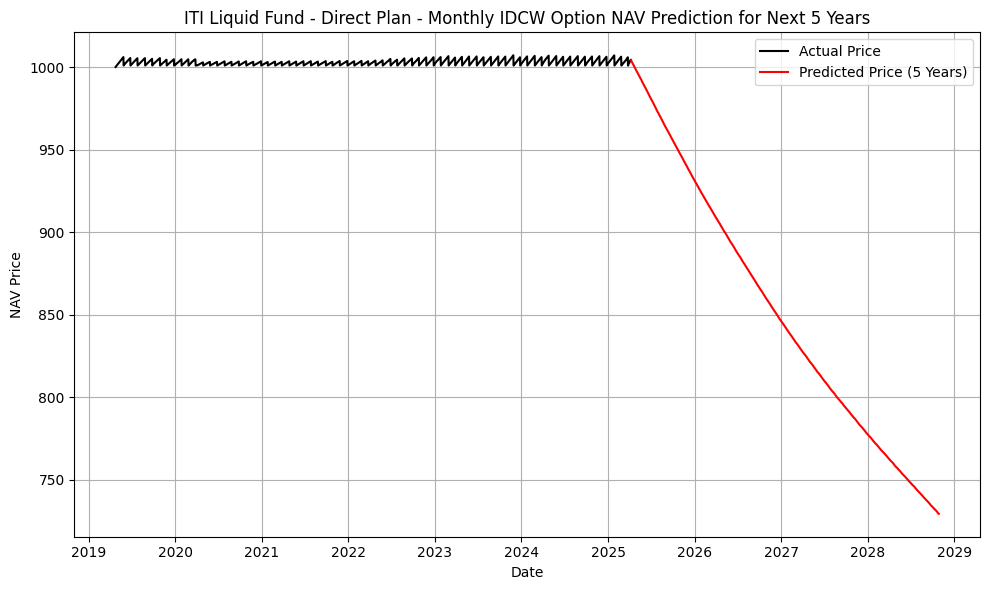

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import requests

# === CONFIGURATION ===
MODEL_PATH = "5Y_LSTM_general_model.h5"  # Path to your general model
ISIN = "INF00XX01358"
SEQ_LEN = 60
FUTURE_DAYS = 260 * 5

# === Load General Model ===
model = load_model(MODEL_PATH)

# === Load Fund Data ===
url = f"https://mf.captnemo.in/nav/{ISIN}"
res = requests.get(url)
nav_data = res.json()

data = pd.DataFrame(nav_data['historical_nav'])
data = data.rename(columns={0: 'Date', 1: 'Price'})
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')
data.set_index('Date', inplace=True)

# === Compute % Change and Scaling ===
nav_prices = data['Price'].values
nav_pct_change = pd.Series(nav_prices).pct_change().dropna().values

if len(nav_pct_change) < SEQ_LEN:
    raise ValueError("Not enough data to get last 60 daily % changes.")

# Use a fresh scaler for prediction OR load from training time if saved
scaler = MinMaxScaler()
scaler.fit(nav_pct_change.reshape(-1, 1))  # Fit on full available history

last_pct_changes = nav_pct_change[-SEQ_LEN:]
scaled_last = scaler.transform(last_pct_changes.reshape(-1, 1))
input_seq = scaled_last.reshape(1, SEQ_LEN, 1)

# === Predict ===
pred_scaled = model.predict(input_seq, verbose=0)[0]
predicted_pct_changes = scaler.inverse_transform(pred_scaled.reshape(-1, 1))

# === Convert back to Price Path ===
last_price = nav_prices[-1]
predicted_prices = [last_price]
for pct in predicted_pct_changes:
    predicted_prices.append(predicted_prices[-1] * (1 + pct[0]))
predicted_prices = predicted_prices[1:]

# === Plot ===
future_dates = pd.date_range(start=data.index[-1], periods=FUTURE_DAYS + 1, freq='D')[1:]

plt.figure(figsize=(10, 6))
plt.plot(data.index, nav_prices, label='Actual Price', color='black')
plt.plot(future_dates, predicted_prices, label='Predicted Price (5 Years)', color='red')
plt.title(f'{nav_data["name"]} NAV Prediction for Next 5 Years')
plt.xlabel('Date')
plt.ylabel('NAV Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, LayerNormalization, Bidirectional, Embedding, Concatenate, Flatten
from sklearn.preprocessing import MinMaxScaler
import requests

# ==== SETTINGS ====
SEQ_LEN = 60
FUTURE_DAYS = 260 * 5
BATCH_SIZE = 64
EPOCHS = 100

# ==== LOAD FUNDS ====
df = pd.read_csv("updated_kuvera_funds.csv")
ISIN_LIST = df["isin"].tolist()[:30]
isin_to_index = {isin: i for i, isin in enumerate(ISIN_LIST)}
NUM_FUNDS = len(ISIN_LIST)

# ==== COLLECT DATA ====
X_nav_all, X_isin_all, y_all = [], [], []
fund_scalers = {}

for isin_number in ISIN_LIST:
    url = f"https://mf.captnemo.in/nav/{isin_number}"
    try:
        res = requests.get(url)
        if res.status_code != 200:
            print(f"⚠️ Failed to fetch for {isin_number}")
            continue

        nav_data = res.json()
        data = pd.DataFrame(nav_data['historical_nav'])
        data.columns = ['Date', 'Price']
        data['Date'] = pd.to_datetime(data['Date'])
        data = data.sort_values('Date')
        data.set_index('Date', inplace=True)

        nav_prices = data['Price'].values
        nav_pct_change = pd.Series(nav_prices).pct_change().dropna().values

        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(nav_pct_change.reshape(-1, 1))

        if len(scaled_data) <= (SEQ_LEN + FUTURE_DAYS):
            print(f"⏭️ Not enough data for {isin_number}")
            continue

        for i in range(SEQ_LEN, len(scaled_data) - FUTURE_DAYS):
            seq_X = scaled_data[i - SEQ_LEN:i]
            seq_y = scaled_data[i:i + FUTURE_DAYS].flatten()
            X_nav_all.append(seq_X)
            y_all.append(seq_y)
            X_isin_all.append([isin_to_index[isin_number]])

        fund_scalers[isin_number] = scaler

    except Exception as e:
        print(f"❌ Error for {isin_number}: {e}")
        continue

# ==== PREPARE DATA ====
X_nav = np.array(X_nav_all).reshape(-1, SEQ_LEN, 1)
X_isin = np.array(X_isin_all)
y = np.array(y_all)

print(f"✅ Final training shape: {X_nav.shape}, ISIN shape: {X_isin.shape}, y shape: {y.shape}")

# ==== MODEL ARCHITECTURE ====
nav_input = Input(shape=(SEQ_LEN, 1), name="nav_sequence_input")
isin_input = Input(shape=(1,), dtype='int32', name="isin_input")

isin_embedding = Embedding(input_dim=NUM_FUNDS, output_dim=8, name="isin_embedding")(isin_input)
isin_embedding_flat = Flatten()(isin_embedding)

x = Bidirectional(LSTM(128, return_sequences=True))(nav_input)
x = LayerNormalization()(x)
x = Dropout(0.3)(x)
x = Bidirectional(LSTM(64))(x)
x = LayerNormalization()(x)
x = Dropout(0.3)(x)

merged = Concatenate()([x, isin_embedding_flat])
x = Dense(64, activation='relu')(merged)
x = Dropout(0.2)(x)
output = Dense(FUTURE_DAYS, name="nav_prediction")(x)

model = Model(inputs=[nav_input, isin_input], outputs=output)
model.compile(optimizer='adam', loss=tf.keras.losses.Huber())
model.summary()

# ==== TRAIN MODEL ====
model.fit(
    {"nav_sequence_input": X_nav, "isin_input": X_isin},
    y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

# ==== SAVE MODEL ====
model.save("5Y_LSTM_bidirectional_embedded.h5")
print("✅ Model saved as '5Y_LSTM_bidirectional_embedded.h5'")

⏭️ Not enough data for INF00XX01317
⏭️ Not enough data for INF00XX01341
⏭️ Not enough data for INF00XX01390
⏭️ Not enough data for INF00XX01408
⏭️ Not enough data for INF00XX01572
⏭️ Not enough data for INF00XX01580
⏭️ Not enough data for INF00XX01598
⏭️ Not enough data for INF00XX01622
⏭️ Not enough data for INF00XX01689
⏭️ Not enough data for INF00XX01697
⏭️ Not enough data for INF00XX01705
⏭️ Not enough data for INF00XX01747
✅ Final training shape: (7917, 60, 1), ISIN shape: (7917, 1), y shape: (7917, 1300)


Model: "functional_67"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ nav_sequence_input  │ (None, 60, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 60, 256)   │    133,120 │ nav_sequence_inp… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 60, 256)   │        512 │ bidirectional[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 60, 256)   │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 128)       │    164,352 │ dropout_2[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ isin_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ bidirectional_1[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ isin_embedding      │ (None, 1, 8)      │        240 │ isin_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 8)         │          0 │ isin_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 136)       │          0 │ dropout_3[0][0],  │
│ (Concatenate)       │                   │            │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,768 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ nav_prediction      │ (None, 1300)      │     84,500 │ dropout_4[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 391,748 (1.49 MB)

 Trainable params: 391,748 (1.49 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 33s 203ms/step - loss: 0.0773
Epoch 2/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 25s 201ms/step - loss: 0.0108
Epoch 3/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 25s 199ms/step - loss: 0.0082
Epoch 4/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 24s 196ms/step - loss: 0.0075
Epoch 5/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 25s 199ms/step - loss: 0.0071
Epoch 6/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 25s 200ms/step - loss: 0.0064
Epoch 7/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 25s 199ms/step - loss: 0.0059
Epoch 8/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 25s 198ms/step - loss: 0.0058
Epoch 9/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 25s 199ms/step - loss: 0.0055
Epoch 10/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 25s 204ms/step - loss: 0.0055
Epoch 11/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 25s 202ms/step - loss: 0.0052
Epoch 12/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 25s 202ms/step - loss: 0.0052
Epoch 13/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 25s 203ms/step - loss: 0.0049
Epoch 14/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 25s 201ms/step - loss: 0.0049
E

✅ Model saved as '5Y_LSTM_bidirectional_embedded.h5'


In [1]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from tensorflow.keras.models import load_model
# from sklearn.preprocessing import MinMaxScaler
# import requests
# ISIN_LIST = df["isin"].tolist()[:30]
# for ISIN in ISIN_LIST:
#     # === CONFIGURATION ===
#     # ISIN = "INF00XX01358"
#     SEQ_LEN = 60
#     FUTURE_DAYS = 260 * 5

#     MODEL_PATH_GENERAL = "5Y_LSTM_general_model.h5"
#     MODEL_PATH_BIDIR = "5Y_LSTM_bidirectional_embedded.h5"

#     # === Load Models ===
#     model_general = load_model(MODEL_PATH_GENERAL)
#     model_bidir = load_model(MODEL_PATH_BIDIR)

#     # === Load NAV Data ===
#     url = f"https://mf.captnemo.in/nav/{ISIN}"
#     res = requests.get(url)
#     nav_data = res.json()

#     data = pd.DataFrame(nav_data['historical_nav'])
#     data = data.rename(columns={0: 'Date', 1: 'Price'})
#     data['Date'] = pd.to_datetime(data['Date'])
#     data = data.sort_values('Date')
#     data.set_index('Date', inplace=True)

#     # === Compute % Change and Scaling ===
#     nav_prices = data['Price'].values
#     nav_pct_change = pd.Series(nav_prices).pct_change().dropna().values

#     if len(nav_pct_change) < SEQ_LEN:
#         raise ValueError("Not enough data to get last 60 daily % changes.")

#     scaler = MinMaxScaler()
#     scaler.fit(nav_pct_change.reshape(-1, 1))  # Fit on full available history

#     last_pct_changes = nav_pct_change[-SEQ_LEN:]
#     scaled_last = scaler.transform(last_pct_changes.reshape(-1, 1))
#     input_seq = scaled_last.reshape(1, SEQ_LEN, 1)

#     # === Predict with General Model ===
#     pred_scaled_general = model_general.predict(input_seq, verbose=0)[0]
#     predicted_pct_changes_general = scaler.inverse_transform(pred_scaled_general.reshape(-1, 1))

#     # === Predict with Bidirectional Embedded Model ===
#     # Create ISIN index vector for embedding model (simulate "1" as embedding index for now)
#     isin_index = np.array([[1]])  # In training, you used a mapping from ISIN to integer index
#     pred_scaled_bidir = model_bidir.predict([input_seq, isin_index], verbose=0)[0]
#     predicted_pct_changes_bidir = scaler.inverse_transform(pred_scaled_bidir.reshape(-1, 1))

#     # === Convert to Price Paths ===
#     last_price = nav_prices[-1]

#     def reconstruct_prices(pct_changes, last_price):
#         prices = [last_price]
#         for pct in pct_changes:
#             prices.append(prices[-1] * (1 + pct[0]))
#         return prices[1:]

#     predicted_prices_general = reconstruct_prices(predicted_pct_changes_general, last_price)
#     predicted_prices_bidir = reconstruct_prices(predicted_pct_changes_bidir, last_price)

#     future_dates = pd.date_range(start=data.index[-1], periods=FUTURE_DAYS + 1, freq='D')[1:]

#     # === Plot Comparison ===
#     plt.figure(figsize=(14, 6))

#     # Actual NAV
#     plt.plot(data.index, nav_prices, label='Actual NAV', color='black')

#     # General LSTM Prediction
#     plt.plot(future_dates, predicted_prices_general, label='General LSTM Prediction', color='blue', linestyle='-')

#     # Bidirectional + Embedding Prediction
#     plt.plot(future_dates, predicted_prices_bidir, label='BiLSTM + ISIN Embedding Prediction', color='green', linestyle='-')

#     plt.title(f'{nav_data["name"]} - NAV Prediction Comparison (5 Years)')
#     plt.xlabel('Date')
#     plt.ylabel('NAV Price')
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()
